## Install the matrice package or upgrade it if already installed

In [6]:
!python -m pip install --upgrade matrice

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 4.8 MB/s eta 0:00:00


## Setting up the credentials
*   ENV
*   MATRICE_ACCESS_KEY_ID
*   MATRICE_SECRET_ACCESS_KEY
*   MATRICE_ACCOUNT_NUMBER








In [1]:
import yaml
import os

class Vars:
    _data = {}
    _path = None

    @classmethod
    def initialize(cls, path):
        cls._path = path
        cls._data = cls.load()

    @classmethod
    def load(cls):
        if cls._path and os.path.exists(cls._path):
            with open(cls._path, 'r') as f:
                return yaml.safe_load(f)
        return {}

    @classmethod
    def get(cls, key):
        if key not in cls._data:
            raise KeyError(f"Variable {key} not found")
        return cls._data[key]

    @classmethod
    def set(cls, key, value):
        cls._data[key] = value
        with open(cls._path, 'w') as f:
            yaml.safe_dump(cls._data, f, default_flow_style=False)


In [2]:
Vars.initialize('vars.yaml')

In [3]:
Vars.set("ENV", "prod")
Vars.set("MATRICE_ACCESS_KEY_ID", "IUN8I5G1MQU6YQ7LZ7J0W")
Vars.set("MATRICE_SECRET_ACCESS_KEY", "MM7AQNMI2PMQ917SGN5NG")
Vars.set("MATRICE_ACCOUNT_NUMBER", "9782886768719887307619115")

In [4]:
import os
os.environ['ENV'] = Vars.get('ENV')
access_key = Vars.get('MATRICE_ACCESS_KEY_ID')
secret_key = Vars.get('MATRICE_SECRET_ACCESS_KEY')
account_number = Vars.get('MATRICE_ACCOUNT_NUMBER')

## Import required matrice modules

In [5]:
from matrice.session import Session
from matrice.projects import Projects
from matrice.dataset import Dataset
from matrice.models import Model
from matrice.deployment import Deployment
from matrice.exported_model import ExportedModel
import sys
import os

## Create Object Detection Project with Matrice SDK

1.   Initialize matrice connection session
2.   List projects in user account
3.   Create the Project
4.   Update the session with the project_id









In [6]:
session_instance = Session(account_number=account_number, access_key=access_key, secret_key=secret_key)
print("A Session has been initialized:", session_instance)

A Session has been initialized: <matrice.session.Session object at 0x783820e19ed0>


In [7]:
projects_list, msg = session_instance.list_projects(project_type="instance_segmentation")

# Check if there is a message or error
if msg:
    print(f"Message: {msg}")

# Print the projects in a formatted manner
for project_name, project_instance in projects_list.items():
    print(f"Project Name: {project_name} | Project ID: {project_instance.project_id}") #To fix: ERROR: May return none and give error if proj is empty list

Message: Projects fetched successfully
Project Name: Road-Lane-Project | Project ID: 68219e390a1d0e31e05fb4f9
Project Name: Image-segmentation-testing | Project ID: 681b0b0aec6782b797b1e38b


In [8]:
project_name = "Road-Lane-Project"
for name, project_instance in projects_list.items():
    if name == project_name:
        projects_instance = Projects(session_instance, project_name=project_name)
        session_instance.update(projects_instance.project_id)
        print(f"Project '{project_name}' already exists. Initialized Projects instance.")
        project_exists = True
        break
    else:
        project_exists = False

if project_exists == False:
    print(f"Creating a new project: {project_name}")

Project 'Road-Lane-Project' already exists. Initialized Projects instance.


In [9]:
import pprint

name = project_name

# Function to create a project
def create_project():
    project_name = name
    input_type = "image"
    output_type = "instance_segmentation"

    enabled_platforms = {
        "matrice": True,
        "android": False,
        "ios": False,
        "tpu": False,
        "intelCPU": False,
        "gcloudGPU": False
    }

    resp, error = session_instance._create_project(project_name, input_type, output_type)
    if error:
        print(f"Error: {error}")
        return None, None
    else:
        print(f"Project created with ID: {resp['_id']}")
        return resp['_id'], resp['name']

# Check if project_id and project_name exist
project_id = None
project_name = None

if not project_exists:
    project_id, project_name = create_project()
else:
    project_id = projects_instance.project_id
    project_name = projects_instance.project_name
    print(f"Project already exists with ID: {project_id} and Name: {project_name}")


print("----------------------------")
print(f"Project ID: {project_id}")
print(f"Project Name: {project_name}")
print("----------------------------")


Project already exists with ID: 68219e390a1d0e31e05fb4f9 and Name: Road-Lane-Project
----------------------------
Project ID: 68219e390a1d0e31e05fb4f9
Project Name: Road-Lane-Project
----------------------------


In [10]:
Vars.set("project_name",project_name)
Vars.set("project_id", project_id)

In [11]:
session_instance.update(project_id)
project_instance = Projects(session_instance, project_name=project_name)
print("A Project class has been initialized",project_instance)

# From next time, for deployment run till here

A Project class has been initialized <matrice.projects.Projects object at 0x783820e1b690>


## Import the Dataset to the project
1. Upload the dataset
2. Start a data import action
3. Check the status of the dataset import action
4. Check the processed dataset information
5. Upload the dataset

For uploading the dataset you have 2 ways -

* Upload the dataset to cloud storage bucket with project.upload_cloud_dataset()
* Upload the dataset from your local storage with project.upload_local_dataset()

In [ ]:
dataset = project_instance.import_local_dataset(
    project_type='instance_segmentation',
    dataset_name='Road-Lane-Dataset',
    file_path = r"/content/road_lane_instance_segmentation.zip",
    dataset_type = "instance_segmentation",
    input_type = "mscoco"
) #THIS runs on backend. CHECK UI and then fetch ds id manually from UI

In [12]:
dataset=Dataset(session_instance,dataset_id='6821e95b77c12201804be5b7') #To EDIT

In [13]:
dataset_id = dataset.dataset_id
# action_id = dataset_action.action_id

print(f"Dataset ID: {dataset_id}")
# print(f"Action ID: {action_id}")

Dataset ID: 6821e95b77c12201804be5b7


In [14]:
Vars.set("dataset_id", dataset.dataset_id)

In [17]:
def print_dataset_info(dataset):

    dataset_id = dataset.dataset_details['_id']
    dataset_name = dataset.dataset_details['name']
    version_status = dataset.dataset_details.get("stats", [{}])[0].get("versionStatus")
    latest_version = dataset.dataset_details['latestVersion']
    no_of_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
    no_of_classes = len(dataset.dataset_details.get('stats', [{}])[0].get('classStat', {}))
    no_of_versions = len(dataset.dataset_details.get('allVersions', []))
    last_updated_at = dataset.dataset_details.get('updatedAt')

    print(f"Dataset ID: {dataset_id}")
    print(f"Dataset Name: {dataset_name}")
    print(f"Version Status: {version_status}")
    print(f"Latest Version: {latest_version}")
    print(f"Number of Samples: {no_of_samples}")
    print(f"Number of Classes: {no_of_classes}")
    print(f"Number of Versions: {no_of_versions}")
    print(f"Last Updated At: {last_updated_at}")

dataset.refresh()
print_dataset_info(dataset)

Dataset ID: 6821e95b77c12201804be5b7
Dataset Name: Untitled Dataset 2025-05-12 17:57:27
Version Status: processed
Latest Version: v1.0
Number of Samples: 1133
Number of Classes: 6
Number of Versions: 1
Last Updated At: 2025-05-12T12:30:28.465Z


In [18]:
from matrice.model_store import get_all_model_families

resp , error , mesage = get_all_model_families( session_instance , project_id , project_type="instance_segmentation" )
print(error)
print("----List of available Detection models on platform----")
# Iterate through each model family in the response
for model_family in resp:
    # Extract _id and modelFamily (model family name)
    model_family_id = model_family.get('_id')
    name = model_family.get('modelFamily')

    # Print in formatted manner
    print(f"ID: {model_family_id}, Model Family Name: {name}")

None
----List of available Detection models on platform----
ID: 67625ff9d6db1ef9132e84e2, Model Family Name: YOLOv8_Instance_Segmentation
ID: 6762c9b45892e63f791b755d, Model Family Name: YOLOv9_Instance_Segmentation


In [19]:
from matrice.model_store import ModelFamily

model_family_id = "67625ff9d6db1ef9132e84e2" #To EDIT from previous result
# Initialize the ModelFamily instance after choosing a Model Family
model_family_instance = ModelFamily(session_instance, model_family_id=model_family_id) # ResNet
print("A ModelFamily instance has been initialized",model_family_instance)

A ModelFamily instance has been initialized <matrice.model_store.ModelFamily object at 0x78382008e250>


In [20]:
# Fetch model architectures
import pprint
arch_resp, error, message = model_family_instance.get_model_archs()
if error:
    print(f"Error: {error}")
else:
    pprint.pprint(arch_resp)
    # Check if resp is a list or a dictionary
    if isinstance(arch_resp, list):
        # Iterate through each model info in the list
        for model_info in arch_resp:
            model_key = model_info["model_key"]
            model_arch_instance = model_info["model_arch_instance"]

            # Extract model information
            model_info_id = model_arch_instance.model_arch_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} |  Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

    elif isinstance(arch_resp, dict):
        # Iterate through each model key in the dictionary
        for model_key, model_arch_instance in arch_resp.items():
            # Extract model information
            model_info_id = model_arch_instance.model_arch_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} | Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

{'yolov8l_seg': <matrice.model_store.ModelArch object at 0x783820077410>,
 'yolov8m_seg': <matrice.model_store.ModelArch object at 0x783821989e10>,
 'yolov8n_seg': <matrice.model_store.ModelArch object at 0x783820ea1dd0>,
 'yolov8s_seg': <matrice.model_store.ModelArch object at 0x7838218af1d0>,
 'yolov8x_seg': <matrice.model_store.ModelArch object at 0x783821d62b10>}
ID: 67625ff9d6db1ef9132e84e3 | Model Name: YOLOv8 Instance Segmentation Nano | Model Key: yolov8n_seg | Params in Millions: 3.4
ID: 67625ff9d6db1ef9132e84e4 | Model Name: YOLOv8 Instance Segmentation Small | Model Key: yolov8s_seg | Params in Millions: 11.8
ID: 67625ff9d6db1ef9132e84e5 | Model Name: YOLOv8 Instance Segmentation Medium | Model Key: yolov8m_seg | Params in Millions: 27.3
ID: 67625ff9d6db1ef9132e84e6 | Model Name: YOLOv8 Instance Segmentation Large | Model Key: yolov8l_seg | Params in Millions: 46
ID: 67625ff9d6db1ef9132e84e7 | Model Name: YOLOv8 Instance Segmentation Xtra Large | Model Key: yolov8x_seg | Par

In [21]:
from matrice.model_store import ModelArch
train_arch = 'yolov8n_seg' #To EDIT from previous result
print("Chosen Training Architecture :" ,train_arch)
model_arch_instance = arch_resp.get(train_arch)
print("Model Architecture instance initialized for chosen training architecture :", model_arch_instance)

Chosen Training Architecture : yolov8n_seg
Model Architecture instance initialized for chosen training architecture : <matrice.model_store.ModelArch object at 0x783820ea1dd0>


In [22]:
import pprint
train_config = model_arch_instance.get_train_config()
print("-----Default Train Config------")
pprint.pprint(train_config)
print("--------------------------------")
print("-------Training instance initialized--------")
# print(train_instance)

-----Default Train Config------
{'action_config': {},
 'checkpoint_type': 'predefined',
 'is_autoML': False,
 'model_arch_id': '67625ff9d6db1ef9132e84e3',
 'model_checkpoint': 'auto',
 'model_config': {'batch_size': [16],
                  'cos_lr': [False],
                  'epochs': [50],
                  'learning_rate': [0.001],
                  'momentum': [0.95],
                  'optimizer': ['auto'],
                  'weight_decay': [0.0005]},
 'model_family_name': 'YOLOv8_Instance_Segmentation',
 'model_inputs': ['image'],
 'model_key': 'yolov8n_seg',
 'model_name': 'YOLOv8 Instance Segmentation Nano',
 'model_outputs': ['instance_segmentation'],
 'params_millions': 3.4,
 'tuning_type': 'default'}
--------------------------------
-------Training instance initialized--------


In [23]:
model_config = train_config['model_config']

# Modify the model_config as needed
# modifications:
#model_config['batch_size'] = [8]
model_config['epochs'] = [40]  #These are hyper-parameters and can be changed
model_config['learning_rate']=[0.01]


# Repass the modified model_config into the train_config
train_config['model_config'] = model_config

# Print the updated train_config
print("-----Updated Model Config------")
pprint.pprint(train_config['model_config'])
print("--------------------------------")

# Print the updated train_config
print("-----Updated Train Config------")
pprint.pprint(train_config)
print("--------------------------------")

-----Updated Model Config------
{'batch_size': [16],
 'cos_lr': [False],
 'epochs': [40],
 'learning_rate': [0.01],
 'momentum': [0.95],
 'optimizer': ['auto'],
 'weight_decay': [0.0005]}
--------------------------------
-----Updated Train Config------
{'action_config': {},
 'checkpoint_type': 'predefined',
 'is_autoML': False,
 'model_arch_id': '67625ff9d6db1ef9132e84e3',
 'model_checkpoint': 'auto',
 'model_config': {'batch_size': [16],
                  'cos_lr': [False],
                  'epochs': [40],
                  'learning_rate': [0.01],
                  'momentum': [0.95],
                  'optimizer': ['auto'],
                  'weight_decay': [0.0005]},
 'model_family_name': 'YOLOv8_Instance_Segmentation',
 'model_inputs': ['image'],
 'model_key': 'yolov8n_seg',
 'model_name': 'YOLOv8 Instance Segmentation Nano',
 'model_outputs': ['instance_segmentation'],
 'params_millions': 3.4,
 'tuning_type': 'default'}
--------------------------------


In [24]:
train_resp , msg , err = project_instance.add_models_for_training(train_config,primary_metric='mAP@50',dataset_id=dataset.dataset_id,dataset_name=dataset.dataset_name,)
print("------------Model added for training----------")
pprint.pprint(train_resp)

[{'modelKey': 'yolov8n_seg', 'autoML': False, 'tuningType': 'default', 'modelCheckpoint': 'auto', 'checkpointType': 'predefined', '_idModelArch': '67625ff9d6db1ef9132e84e3', 'modelFamilyName': 'YOLOv8_Instance_Segmentation', 'actionConfig': {}, 'modelConfig': {'optimizer': ['auto'], 'cos_lr': [False], 'batch_size': [16], 'epochs': [40], 'learning_rate': [0.01], 'momentum': [0.95], 'weight_decay': [0.0005]}, 'modelName': 'YOLOv8 Instance Segmentation Nano', 'paramsInMillion': 3.4, 'modelInputs': ['image'], 'modelOutputs': ['instance_segmentation'], 'targetRuntime': ['PyTorch'], '_idDataset': '6821e95b77c12201804be5b7', 'datasetVersion': 'v1.0', 'primaryMetric': 'mAP@50', 'datasetName': 'Untitled Dataset 2025-05-12 17:57:27', 'computeAlias': ''}]
{'success': True, 'code': 200, 'message': 'Success', 'serverTime': '2025-05-13T06:46:32Z', 'data': [{'_id': '6822eac7ba25d9750f40e218', '_idDataset': '6821e95b77c12201804be5b7', '_idActionStatus': '6822eac70a1d0e31e05fbc65', '_idModelFamily': '0

In [25]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = train_resp[0]['_idActionStatus']
success_status = 'SUCCESS'
time_sec = 60

# Function to check the status of the action
def check_action_status(S, action_id):
    action_instance = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {action_instance.status}")
    print(f"Step Code: {action_instance.step_code}")
    print(f"Action service is : {action_instance.service_name}")
    print("---------------------")
    return action_instance.status

# Loop to check status every 2 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully trained.")
        break
    else:
        print(f"Model is training. Waiting {time_sec} seconds before checking again.")
        time.sleep(time_sec)


---------------------
Action ID: 6822eac70a1d0e31e05fbc65
Current Status: ACK
Step Code: SCLS_QUE_PROC
Action service is : be-model
---------------------
Model is training. Waiting 60 seconds before checking again.
---------------------
Action ID: 6822eac70a1d0e31e05fbc65
Current Status: OK
Step Code: SCLS_LNCH_CMPI
Action service is : be-model
---------------------
Model is training. Waiting 60 seconds before checking again.
---------------------
Action ID: 6822eac70a1d0e31e05fbc65
Current Status: OK
Step Code: SCLS_LNCH_CMPI
Action service is : be-model
---------------------
Model is training. Waiting 60 seconds before checking again.
---------------------
Action ID: 6822eac70a1d0e31e05fbc65
Current Status: OK
Step Code: SCLS_LNCH_CMPI
Action service is : be-model
---------------------
Model is training. Waiting 60 seconds before checking again.
---------------------
Action ID: 6822eac70a1d0e31e05fbc65
Current Status: OK
Step Code: JBSS_LCK
Action service is : be-model
--------------

In [26]:
model_id = train_resp[0]['_id']
print(f"Model ID from response data: {model_id}")


# Initialize the Model class with the model_id
model_instance = Model(session_instance, model_id)
print("A Model instance has been initialized : ", model_instance)

Model ID from response data: 6822eac7ba25d9750f40e218
A Model instance has been initialized :  <matrice.models.Model object at 0x783821bac450>


In [27]:
# Print the test score, validation score, and best epoch
print(f"Test Score: {model_instance.test_score}")
print(f"Validation Score: {model_instance.val_score}")
print(f"Best Epoch: {model_instance.best_epoch}")

Test Score: 0.5546588217890344
Validation Score: 0.5099757419671328
Best Epoch: -1


In [28]:
Vars.set("model_train_id", model_instance.model_id)

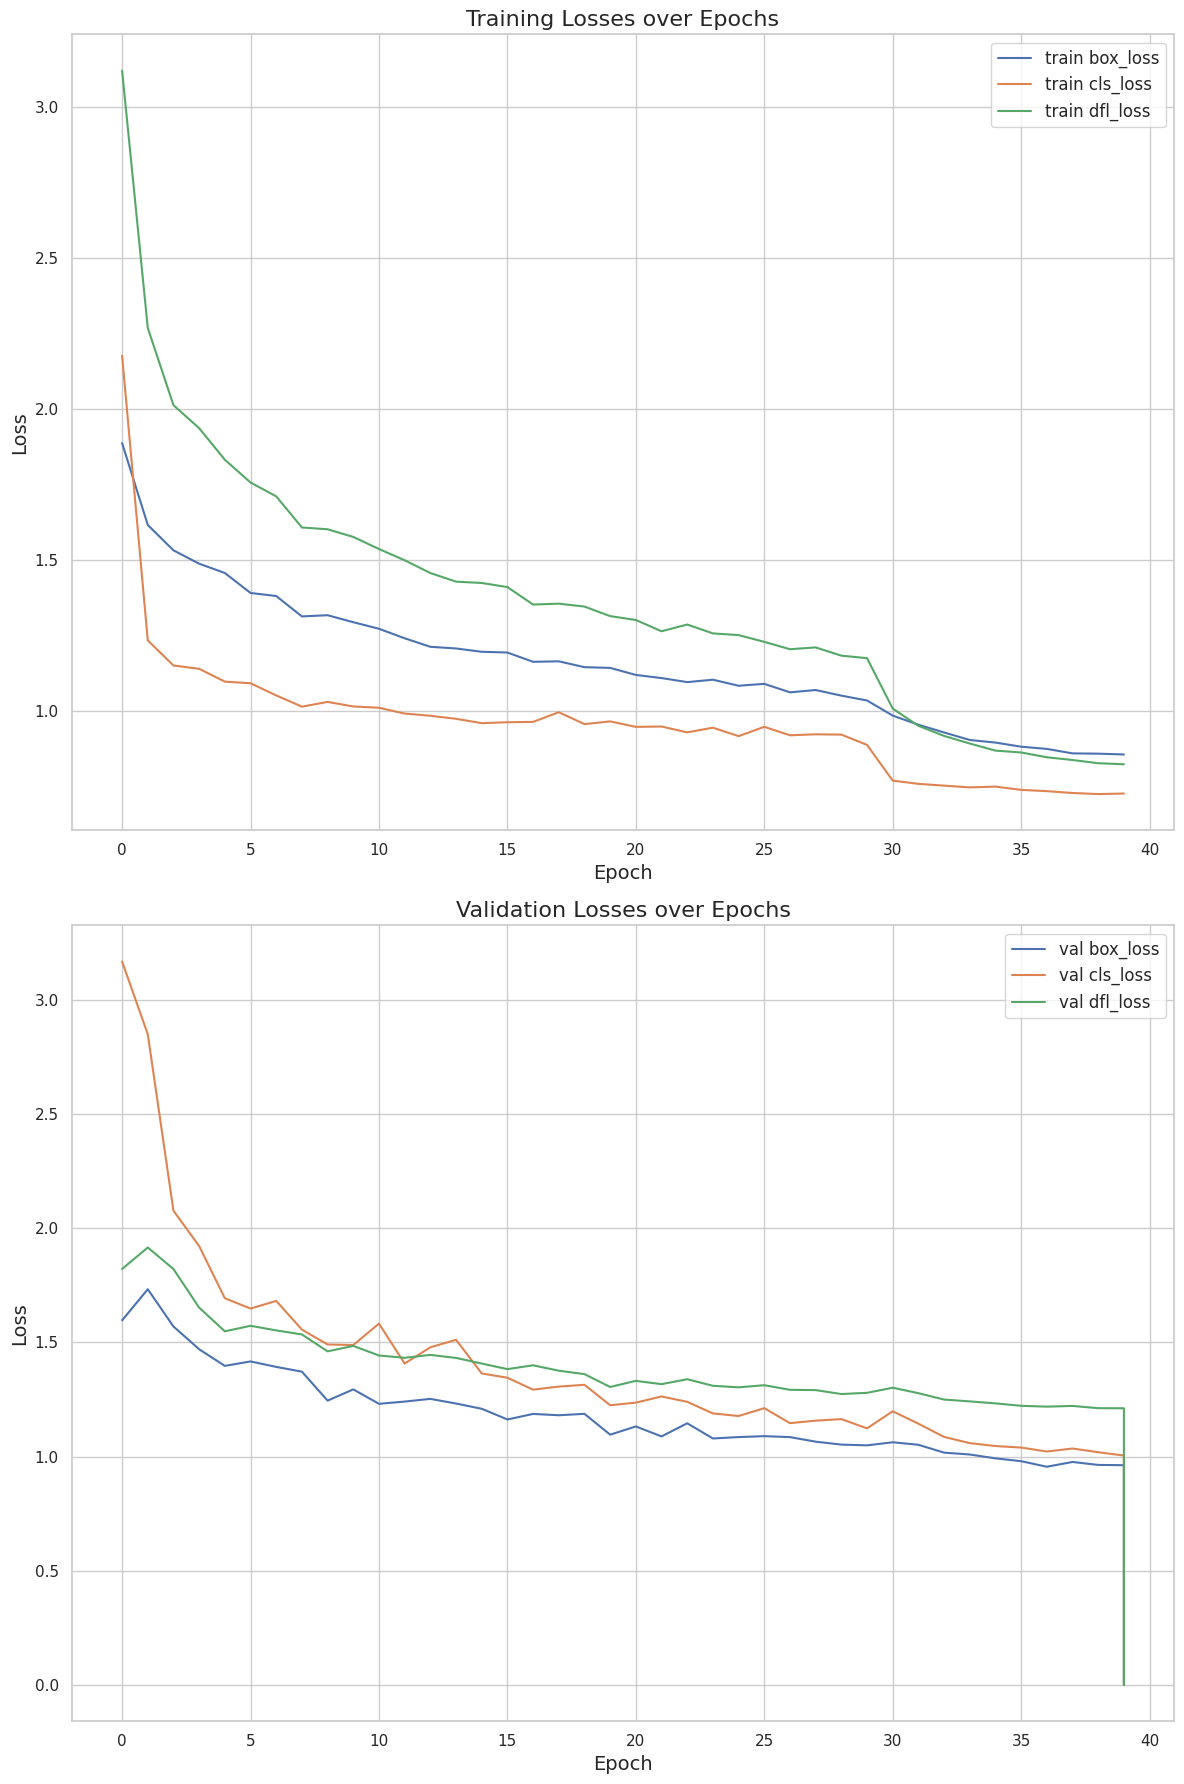

In [29]:
model_instance.plot_epochs_losses()

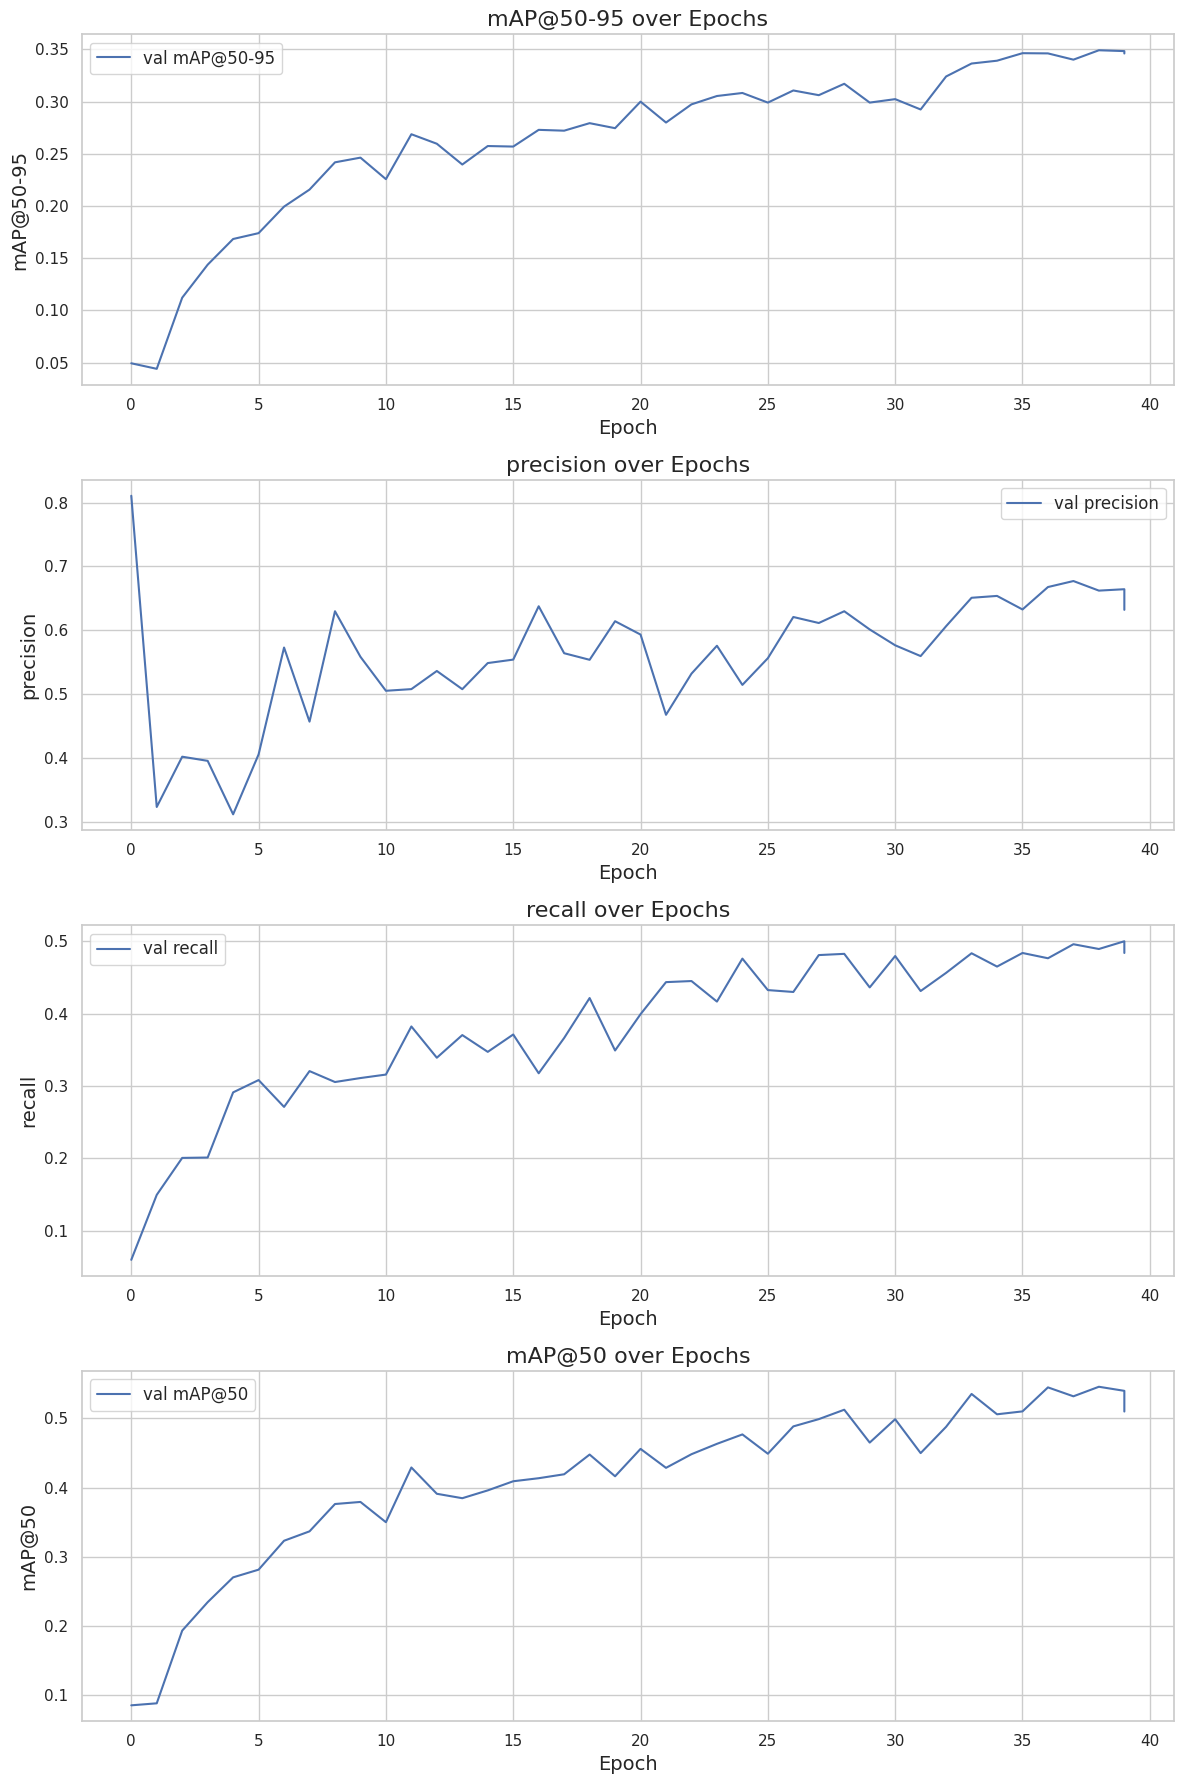

In [30]:
model_instance.plot_epochs_metrics()

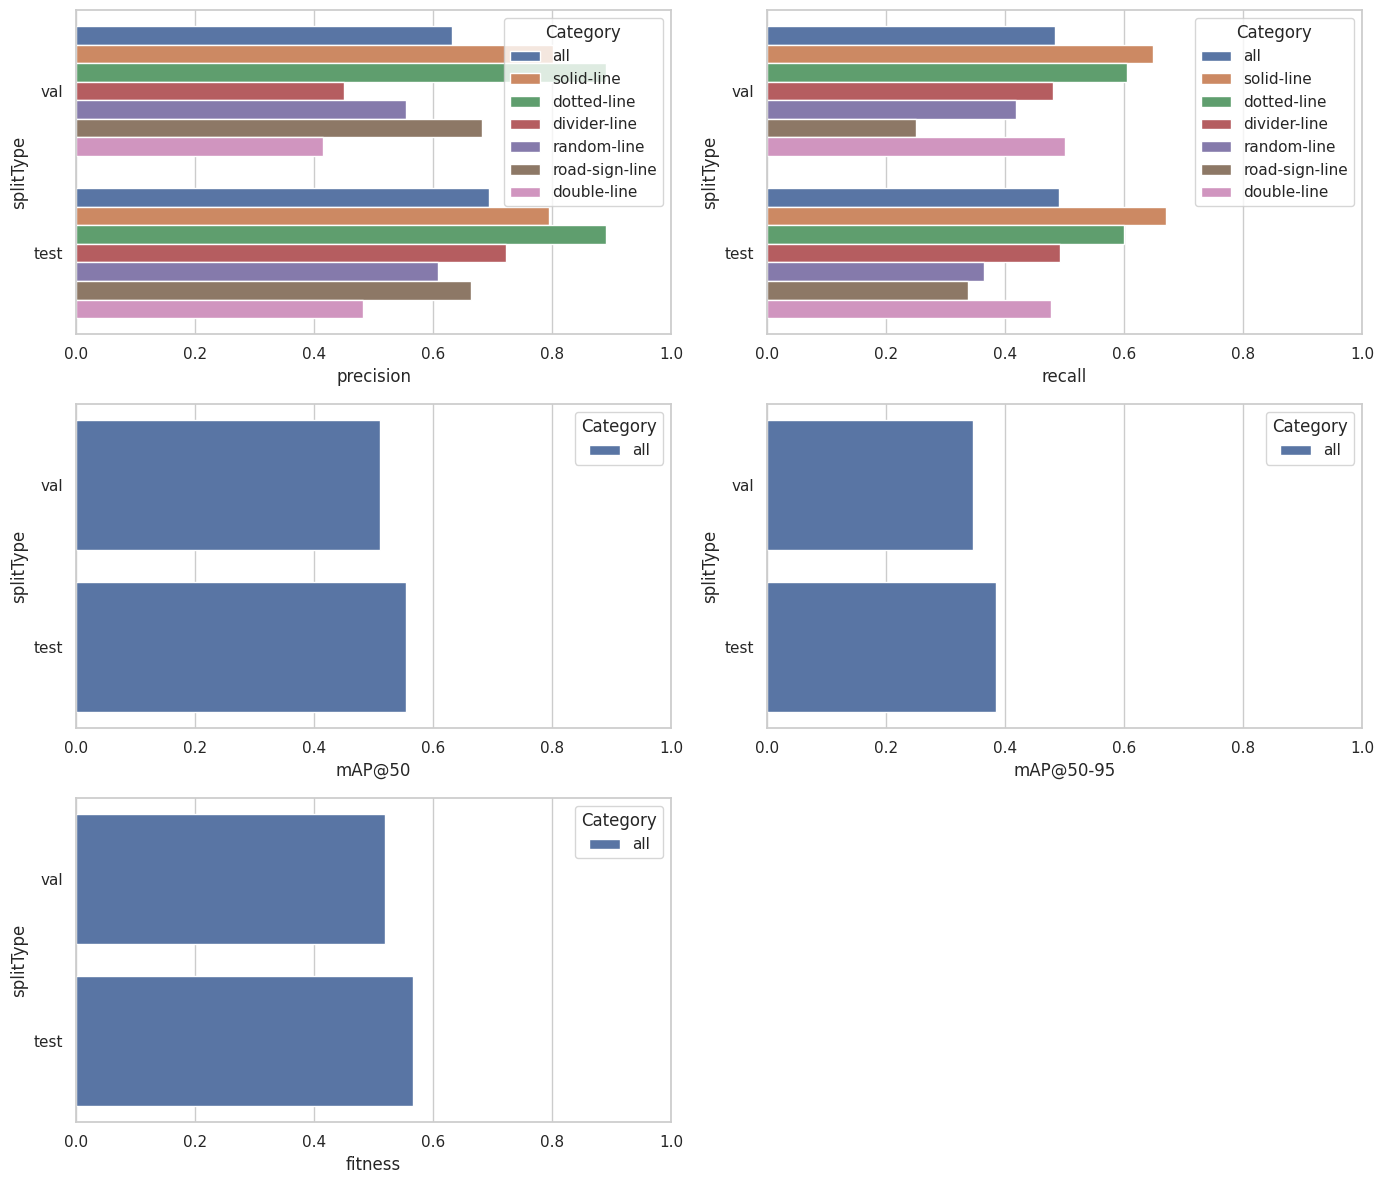

In [31]:
model_instance.plot_eval_results()

## Create a Model Training experiment
1. Start a Model Training experiment
2. Explore the available SOTA model families and models
3. Get the default training config , modify it if needed.
4. Add the model for training.
5. Check for the status of the model train action

In [32]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 797.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Running inference on: /content/test/2023-06-15_14-07-51-front_mp4_1020_jpg.rf.4ffd1619c0c6838fa9ff518836baf625.jpg

image 1/1 /content/test/2023-06-15_14-07-51-front_mp4_1020_jpg.rf.4ffd1619c0c6838fa9ff518836baf625.jpg: 640x640 2 solid-lines, 6 dotted-lines, 276.0ms
Speed: 2.8ms preprocess, 276.0ms inference, 47.1ms postprocess per image at shape (1, 3, 640, 640)


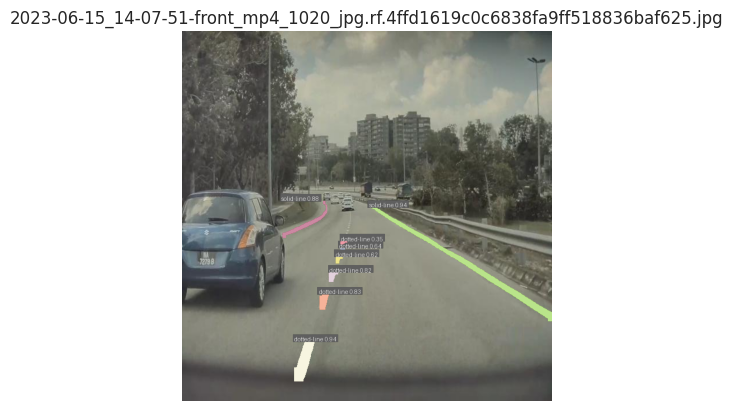

Running inference on: /content/test/Virtual_Driving_Tour_around_Senegal_mp4_16140_jpg.rf.a6be253a17566b165d0a83140f9f68d1.jpg

image 1/1 /content/test/Virtual_Driving_Tour_around_Senegal_mp4_16140_jpg.rf.a6be253a17566b165d0a83140f9f68d1.jpg: 640x640 3 solid-lines, 270.7ms
Speed: 3.9ms preprocess, 270.7ms inference, 26.7ms postprocess per image at shape (1, 3, 640, 640)


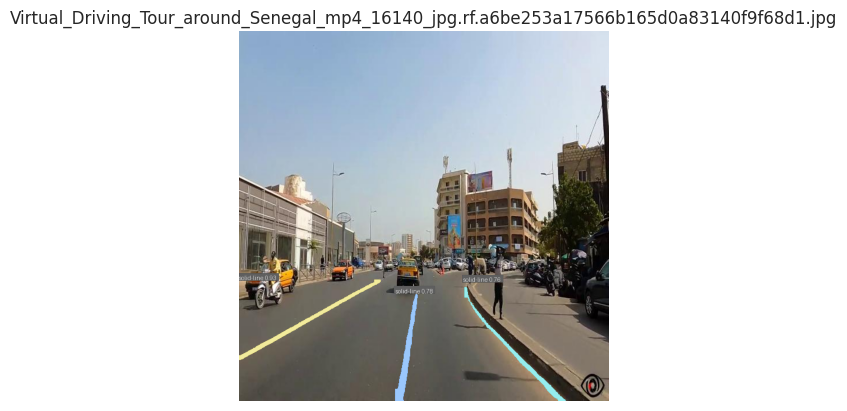

Running inference on: /content/test/2023-06-15_14-38-01-front_mp4_1500_jpg.rf.c2d98a83baa10d6f1cd0c5ca2d3862d5.jpg

image 1/1 /content/test/2023-06-15_14-38-01-front_mp4_1500_jpg.rf.c2d98a83baa10d6f1cd0c5ca2d3862d5.jpg: 640x640 2 solid-lines, 4 dotted-lines, 1 divider-line, 2 road-sign-lines, 271.9ms
Speed: 3.5ms preprocess, 271.9ms inference, 56.0ms postprocess per image at shape (1, 3, 640, 640)


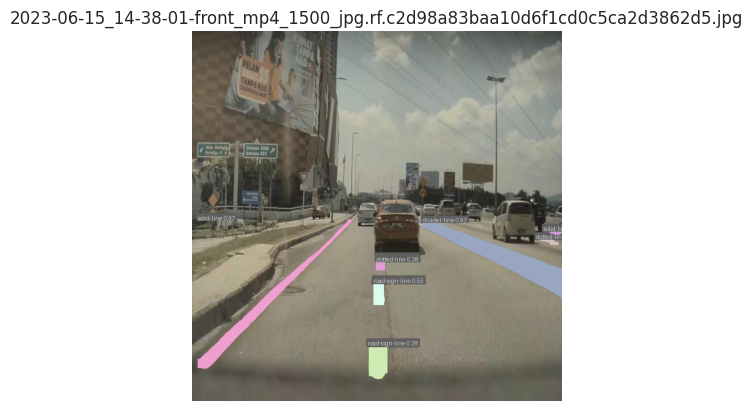

Running inference on: /content/test/2023-06-15_14-13-53-front_mp4_1860_jpg.rf.476764316faa3316549cde7efa343583.jpg

image 1/1 /content/test/2023-06-15_14-13-53-front_mp4_1860_jpg.rf.476764316faa3316549cde7efa343583.jpg: 640x640 2 solid-lines, 8 dotted-lines, 279.1ms
Speed: 3.5ms preprocess, 279.1ms inference, 75.6ms postprocess per image at shape (1, 3, 640, 640)


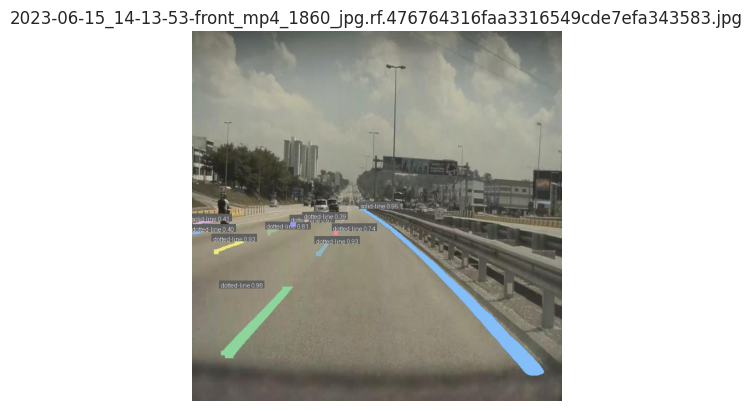

Running inference on: /content/test/Malaysia_Dash_Cam_Video_Compilation_14_Malaysian_Dash_Cam_Owners_mp4_3840_jpg.rf.1c51ba0c2e7c59a47a819f5317653a30.jpg

image 1/1 /content/test/Malaysia_Dash_Cam_Video_Compilation_14_Malaysian_Dash_Cam_Owners_mp4_3840_jpg.rf.1c51ba0c2e7c59a47a819f5317653a30.jpg: 640x640 1 solid-line, 7 dotted-lines, 1 divider-line, 2 road-sign-lines, 271.3ms
Speed: 3.3ms preprocess, 271.3ms inference, 104.2ms postprocess per image at shape (1, 3, 640, 640)


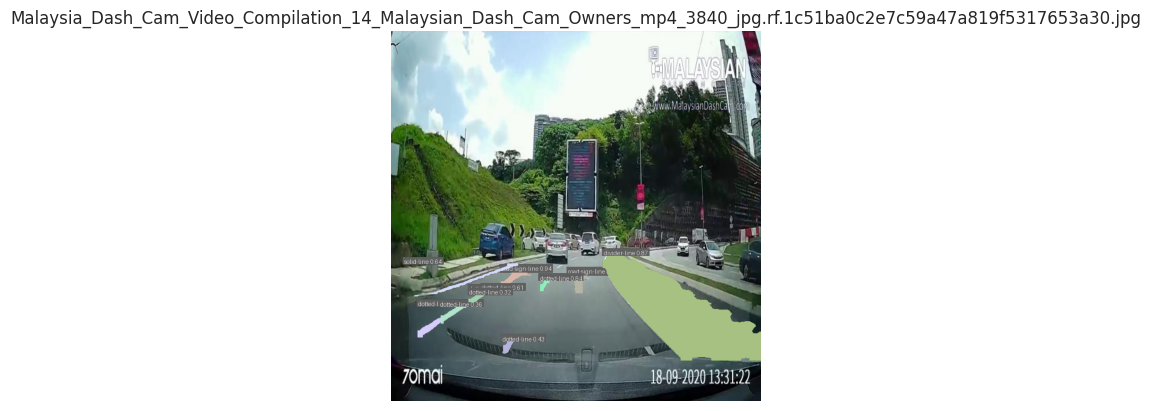

Running inference on: /content/test/Malaysia_Dash_Cam_Video_Compilation_1_Malaysian_Dash_Cam_Owners_mp4_960_jpg.rf.bdd0a3f44f201c9a1af5119983518662.jpg

image 1/1 /content/test/Malaysia_Dash_Cam_Video_Compilation_1_Malaysian_Dash_Cam_Owners_mp4_960_jpg.rf.bdd0a3f44f201c9a1af5119983518662.jpg: 640x640 2 solid-lines, 4 dotted-lines, 298.4ms
Speed: 4.2ms preprocess, 298.4ms inference, 37.8ms postprocess per image at shape (1, 3, 640, 640)


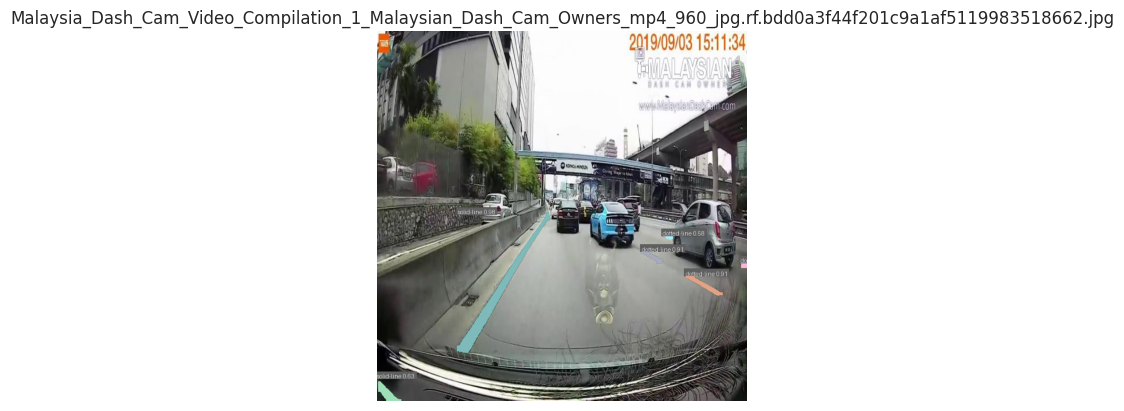

Running inference on: /content/test/20230619164257_247480_TS_2220_jpg.rf.679a162ad2c174bd64b12ec172dce05f.jpg

image 1/1 /content/test/20230619164257_247480_TS_2220_jpg.rf.679a162ad2c174bd64b12ec172dce05f.jpg: 640x640 2 solid-lines, 287.6ms
Speed: 6.3ms preprocess, 287.6ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)


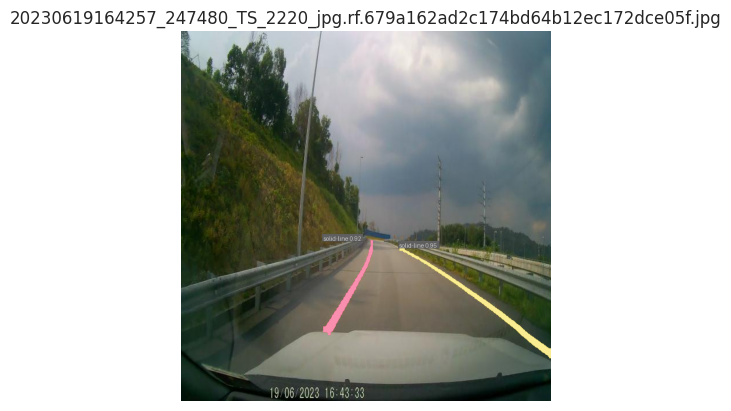

In [35]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import random

# Load the trained model
model = YOLO("/content/best.pt")

# Get all .jpg files in /content/test
image_paths = glob.glob("/content/test/*.jpg")

# Load a font (default PIL font if custom font not available)
try:
    font = ImageFont.truetype("arial.ttf", 16)
except IOError:
    font = ImageFont.load_default()

# Helper to generate random colors
def random_color():
    return tuple(random.choices(range(256), k=3)) + (128,)  # RGBA with transparency

# Iterate over images and run inference
for photo in image_paths:
    print(f"Running inference on: {photo}")
    results = model(photo)

    # Load the original image
    img = Image.open(photo).convert("RGBA")
    draw = ImageDraw.Draw(img)

    # Iterate through the detected objects
    for i, mask in enumerate(results[0].masks.xy):
        polygon = [(int(x), int(y)) for x, y in mask]
        color = random_color()

        # Draw the segmentation mask
        draw.polygon(polygon, fill=color)

        # Get box and label info
        if results[0].boxes:
            box = results[0].boxes.xyxy[i].cpu().numpy()
            class_id = int(results[0].boxes.cls[i])
            conf = float(results[0].boxes.conf[i])
            label = f"{model.names[class_id]} {conf:.2f}"
            x1, y1, _, _ = box

            # Adjust font size based on image width
            img_width, img_height = img.size
            font_size = max(50, img_width // 10)  # Dynamic font sizing
            try:
                font = ImageFont.truetype("arial.ttf", font_size)
            except IOError:
                font = ImageFont.load_default()

            # Measure text size
            text_size = draw.textbbox((x1, y1), label, font=font)
            text_width = text_size[2] - text_size[0]
            text_height = text_size[3] - text_size[1]

            # Draw background rectangle for better contrast
            padding = 2
            background_box = [x1 - padding, y1 - text_height - padding, x1 + text_width + padding, y1 + padding]
            draw.rectangle(background_box, fill=(0, 0, 0, 160))  # semi-transparent black background

            # Draw text on top
            draw.text((x1, y1 - text_height), label, font=font, fill=(255, 255, 255, 255))


    # Display the image with masks and labels
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(photo))
    plt.show()


In [38]:
model_instance.download_model(file_name="model.pt")

Model downloaded successfully


'model.pt'

## Export the model based on usage and platform and optimzie the Model Export
1. Create a model export action using the export config
2. Check the status of the model export action
3. Download the exported model

In [43]:
export_config = train_instance.get_default_export_config("ONNX") # Get the default export config for export format user wants (here ONNX)
print("Export Config for ONNX:")
pprint.pprint(export_config)

NameError: name 'train_instance' is not defined

In [ ]:
exported_instance , action_instance = project_instance.create_model_export(model_id,"ONNX",export_config)

print("Model Export class has been initialized :", exported_instance )
print("----------------------------")
print(f"Export ID: {exported_instance.model_export_id}")
print(f"Export Name: {exported_instance.model_export_name}")
print(f"Action ID: {action_instance.action_id}")
print(f"Action Status: {action_instance.status}")
print("----------------------------")

In [ ]:
Vars.set("model_export_id", exported_instance.model_export_id)
Vars.set("model_export_name", exported_instance.model_export_name)

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = action_instance.action_id
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    A = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {A.status}")
    print(f"Step Code: {A.step_code}")
    print(f"Action service is : {A.service_name}")
    print("---------------------")
    return A.status

# Loop to check status every 1.5 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully exported.")
        break
    else:
        print("Model is exporting. Waiting 2 minutes before checking again.")
        time.sleep(90)  # Wait for 1.5 minutes (90 seconds)


In [ ]:
exported_instance.download_model(file_name="model.onnx")

## Deploy the Model on Cloud
* Start a Model Deployment server
* Make Predictions on the Deployed Model

In [42]:
deployment , deployment_action = project_instance.create_fastapi_deployment(
    model_id = "6822eac7ba25d9750f40e218",  # It can also be model_train_id depending on the model you want to deploy
    deployment_name = "deployment_test_2",
    shutdown_threshold=25
) #again this WILL GIVE ERROR BUT IT WORKS ON BACKEND. CHECK UI

An error occurred while trying to create deployment. Deployment with given name already exists


AssertionError: Either deployment_id or deployment_name must be provided

In [ ]:
deployment=Deployment(session_instance,deployment_id='68220bb8bc5142b71457294b', deployment_name='deployment_test_2') #fetch dp id manually from UI and name can be changed

In [ ]:
key_resp = deployment.create_auth_key(2) # key is valid for 1 day
# auth_key = key_resp['key']
auth_key = key_resp[0]['key']
print(auth_key)

6822126dbc5142b714572b44


In [ ]:
Vars.set("deployment_id", deployment.deployment_id)
Vars.set("deployment_name", deployment.deployment_name)
Vars.set("auth_key", auth_key)

In [40]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# THIS ENTRIE CODE NEEDS TO BE MODIFITED WRT INSTANCE_SEGMENTATION
# Define the folder path containing the images
folder_path = r"/content/test"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 2)


# Loop through the selected images and send the prediction request
for image_file in random_images:

    result, error, message = deployment.get_prediction(auth_key,image_file)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()


NameError: name 'deployment' is not defined